In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

2026-02-23 13:14:25.929336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771852466.248096      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771852466.339380      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
df = pd.read_csv("/kaggle/input/aircraft-data-from-nov-2022-through-dec-31-2022/aircraft-data_nov_dec.csv")

In [3]:
# EDA
print("Shape:", df.shape)
df.head()

Shape: (30947, 14)


,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/24,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/22 13:30
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/24,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/22 13:30
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/24,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/22 13:30
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/24,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/22 13:30
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/24,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/22 13:40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight          30915 non-null  object 
 1   tail_number     30947 non-null  object 
 2   long            30947 non-null  float64
 3   lat             30947 non-null  float64
 4   alt             30947 non-null  int64  
 5   manufacturer    30185 non-null  object 
 6   model           30185 non-null  object 
 7   reg_expiration  29958 non-null  object 
 8   reg_owner       30184 non-null  object 
 9   reg_city        30340 non-null  object 
 10  reg_state       30337 non-null  object 
 11  squawk          29053 non-null  float64
 12  mph             30947 non-null  int64  
 13  spotted         30947 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 3.3+ MB


In [5]:
df.isna().sum()

flight              32
tail_number          0
long                 0
lat                  0
alt                  0
manufacturer       762
model              762
reg_expiration     989
reg_owner          763
reg_city           607
reg_state          610
squawk            1894
mph                  0
spotted              0
dtype: int64

Quantify missing values in each column to determine which features require cleaning before modeling.

In [6]:
df = df.dropna(subset=["mph", "alt", "lat", "long"])

Remove rows missing essential numerical features (speed, altitude, latitude, longitude) required for anomaly detection.

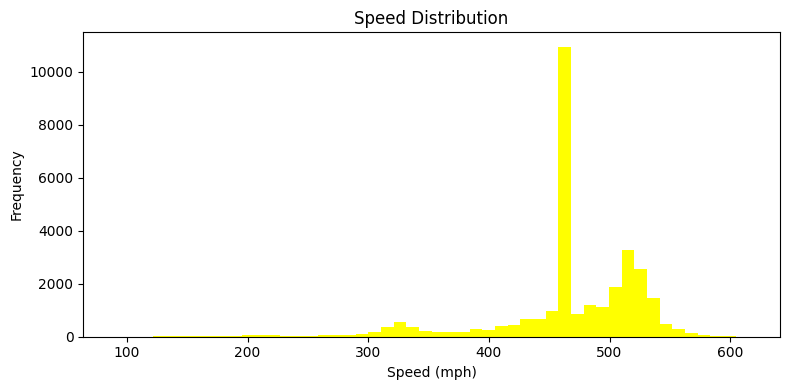

In [7]:
plt.figure(figsize=(8,4))
plt.hist(df["mph"], bins=50, color="yellow")
plt.xlabel("Speed (mph)")
plt.ylabel("Frequency")
plt.title("Speed Distribution")
plt.tight_layout()
plt.show()


Visualize the distribution of aircraft speed (mph) to understand normal operating ranges and potential outliers.

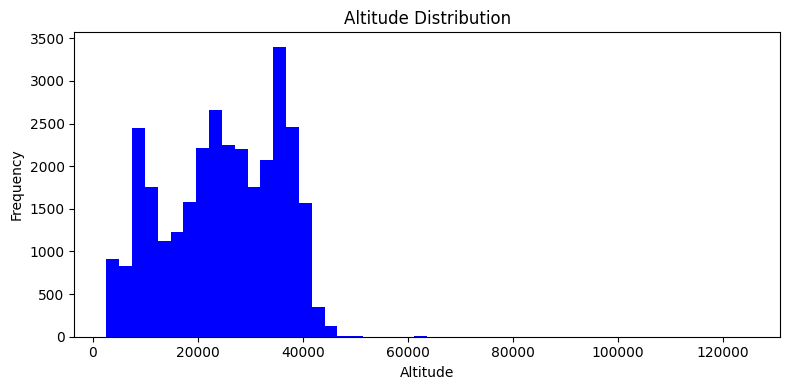

In [8]:
plt.figure(figsize=(8,4))
plt.hist(df["alt"], bins=50, color="blue")
plt.xlabel("Altitude")
plt.ylabel("Frequency")
plt.title("Altitude Distribution")
plt.tight_layout()
plt.show()


Analyze altitude distribution to identify abnormal flight levels or extreme altitude values.

In [9]:
df["spotted"] = pd.to_datetime(df["spotted"])

/tmp/ipykernel_47/663774712.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["spotted"] = pd.to_datetime(df["spotted"])


Convert the `spotted` column to datetime format to enable time-based analysis and visualization.

In [10]:
df["spotted"] = pd.to_datetime(df["spotted"], errors="coerce")

Ensure invalid or corrupted timestamps are safely converted to NaT using error coercion.

In [11]:
df["vertical_rate"] = df["alt"].diff().fillna(0)


Ensure invalid or corrupted timestamps are safely converted to NaT using error coercion.

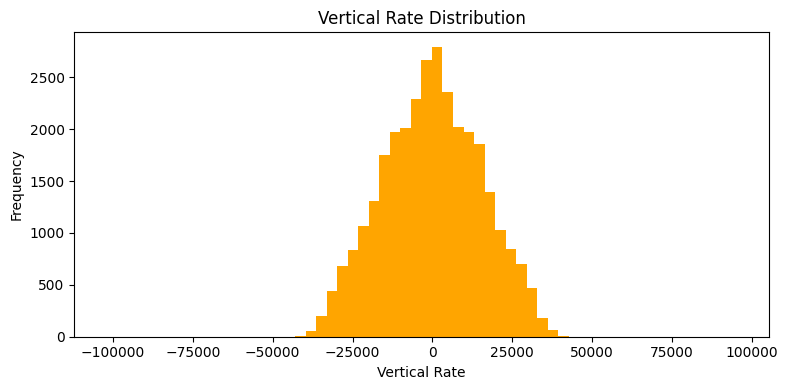

In [12]:
plt.figure(figsize=(8,4))
plt.hist(df["vertical_rate"], bins=60, color="orange")
plt.xlabel("Vertical Rate")
plt.ylabel("Frequency")
plt.title("Vertical Rate Distribution")
plt.tight_layout()
plt.show()

Create a derived feature representing vertical movement by computing altitude change between consecutive records.

In [13]:
df["trajectory_change"] = (
    df["lat"].diff().abs() + df["long"].diff().abs()
).fillna(0)

Create a derived feature representing vertical movement by computing altitude change between consecutive records.

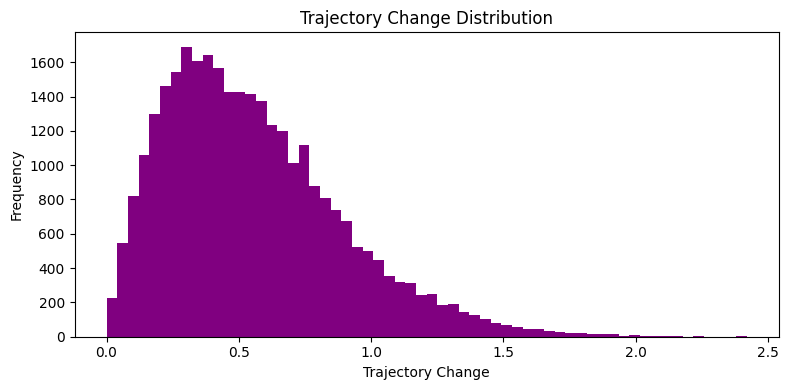

In [14]:
plt.figure(figsize=(8,4))
plt.hist(df["trajectory_change"], bins=60, color="purple")
plt.xlabel("Trajectory Change")
plt.ylabel("Frequency")
plt.title("Trajectory Change Distribution")
plt.tight_layout()
plt.show()


In [15]:
features = [
    "mph",                # speed
    "alt",                # altitude
    "vertical_rate",      # altitude change
    "trajectory_change"   # position change
]

X = df[features].dropna().values
X = tf.convert_to_tensor(X, dtype=tf.float32)


2026-02-23 13:14:55.207341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Select numerical features relevant to flight behavior for multivariate anomaly detection.

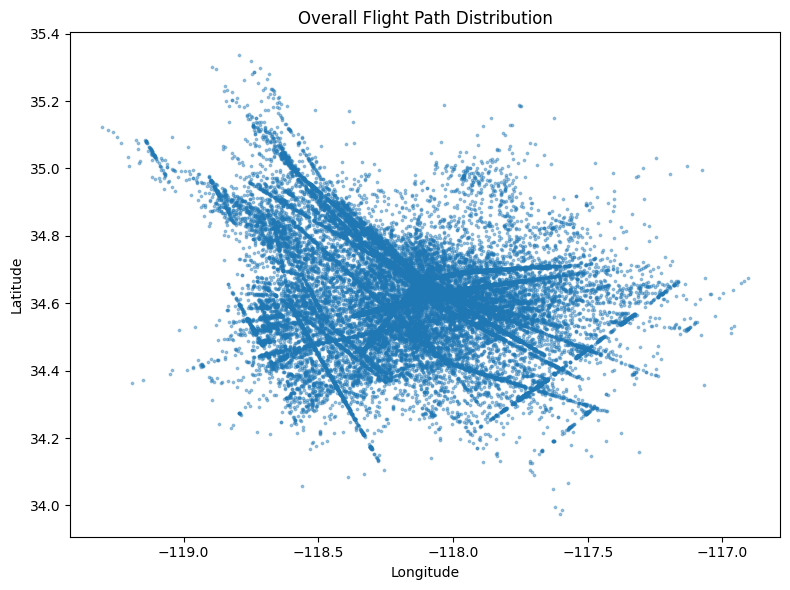

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(df["long"], df["lat"], s=3, alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Overall Flight Path Distribution")
plt.tight_layout()
plt.show()

Plot aircraft latitude and longitude to visually inspect flight path density and geographic anomalies.

In [17]:
tfd = tfp.distributions

mu = tf.reduce_mean(X, axis=0)
cov = tfp.stats.covariance(X)

gaussian = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov
)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Fit a multivariate normal distribution using feature means and covariance to model normal flight behavior.

In [18]:
p = gaussian.prob(X)

Compute the likelihood of each data point under the Gaussian model to quantify normality.

In [19]:
epsilon = tf.sort(p)[int(0.01 * p.shape[0])]

Define an anomaly threshold using the lowest 1% of probability values to flag rare flight patterns.

In [20]:
anomalies = p < epsilon

df_result = df.iloc[:len(p)].copy()
df_result["anomaly"] = anomalies.numpy()


Classify flights as normal or anomalous based on whether their probability falls below the threshold.

In [21]:
df_result["anomaly"]

0        False
1        False
2        False
3        False
4        False
         ...  
30942    False
30943    False
30944    False
30945    False
30946    False
Name: anomaly, Length: 30947, dtype: bool

In [22]:
total_points = len(df_result)
anomaly_count = df_result["anomaly"].sum()
normal_count = total_points - anomaly_count

print("Total points:", total_points)
print("Anomalies detected:", anomaly_count)
print("Normal points:", normal_count)


Total points: 30947
Anomalies detected: 309
Normal points: 30638


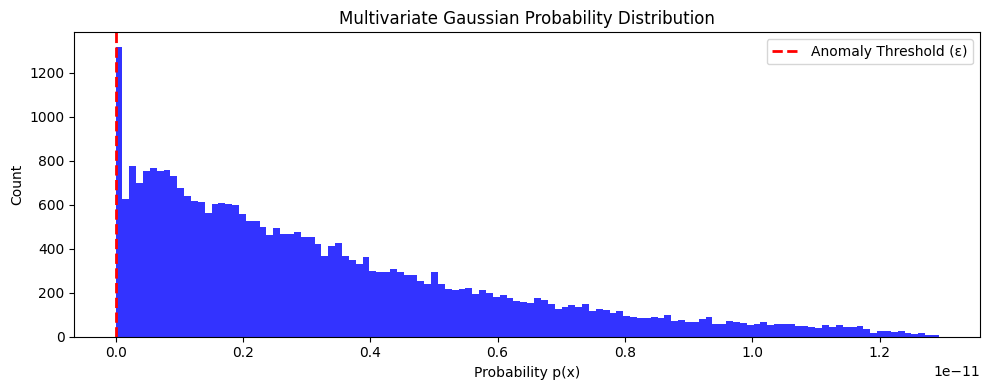

In [23]:
plt.figure(figsize=(10,4))
plt.hist(p.numpy(), bins=120, color="blue", alpha=0.8)
plt.axvline(epsilon.numpy(), color="red", linestyle="--", linewidth=2,
            label="Anomaly Threshold (ε)")
plt.xlabel("Probability p(x)")
plt.ylabel("Count")
plt.title("Multivariate Gaussian Probability Distribution")
plt.legend()
plt.tight_layout()
plt.show()


Visualize probability density distribution to understand separation between normal and anomalous points.

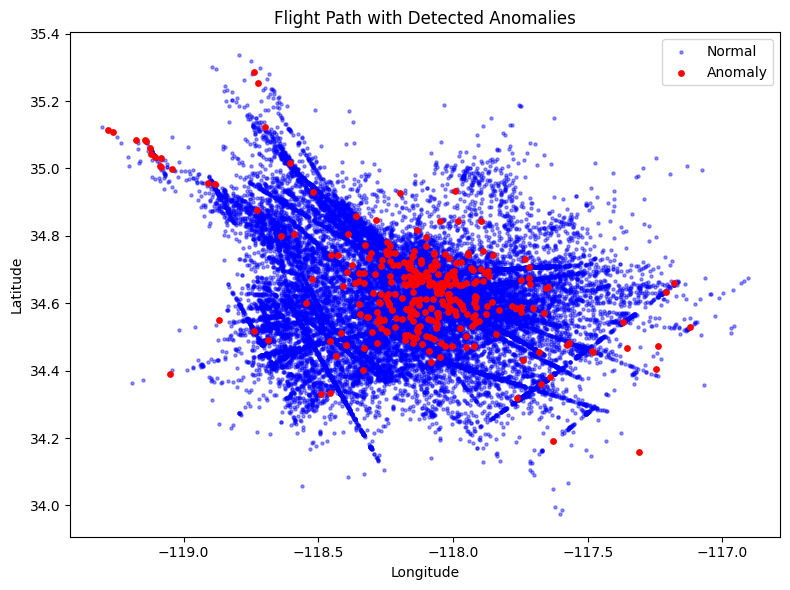

In [24]:
plt.figure(figsize=(8,6))

# Normal points
normal = df_result[~df_result["anomaly"]]
anomaly = df_result[df_result["anomaly"]]

plt.scatter(
    normal["long"], normal["lat"],
    s=5, c="blue", alpha=0.4, label="Normal"
)

plt.scatter(
    anomaly["long"], anomaly["lat"],
    s=15, c="red", label="Anomaly"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flight Path with Detected Anomalies")
plt.legend()
plt.tight_layout()
plt.show()


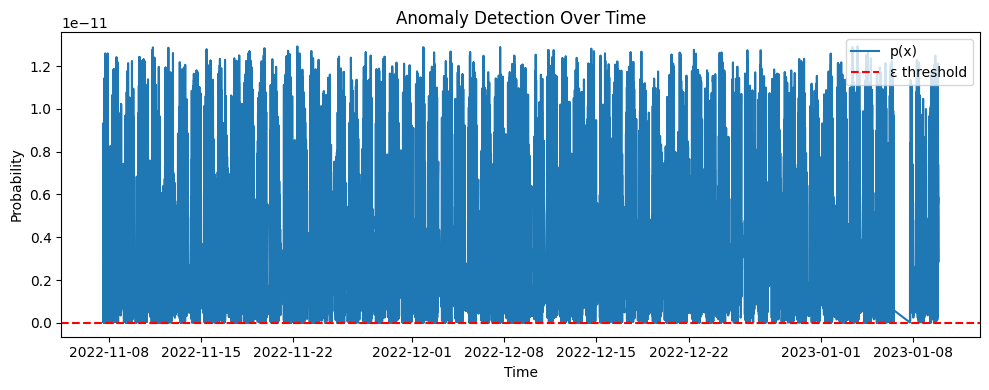

In [25]:
plt.figure(figsize=(10,4))

plt.plot(df_result["spotted"], p.numpy(), label="p(x)")
plt.axhline(epsilon.numpy(), color="red", linestyle="--", label="ε threshold")

plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Anomaly Detection Over Time")
plt.legend()
plt.tight_layout()
plt.show()

